In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors


In [5]:
#read data into dataframes
anime_data = pd.read_csv("data/anime.csv")
anime_user_ratings = pd.read_csv("data/animelist.csv")
synopsis_df = pd.read_csv("data/anime_with_synopsis.csv")
anime_data = anime_data.rename(columns = {"MAL_ID": "anime_id"})
anime_id_to_name = anime_data[["anime_id", "Name"]]

In [6]:
# create dataframe showing every rating and anime name
ratings_df = anime_user_ratings.merge(anime_id_to_name, left_on = 'anime_id', right_on = 'anime_id', how = 'left')
ratings_df = ratings_df[["user_id", "Name", "anime_id","rating","watching_status"]]
ratings_df.head()

,user_id,Name,anime_id,rating,watching_status
0,0,Basilisk: Kouga Ninpou Chou,67,9,1
1,0,Fairy Tail,6702,7,1
2,0,Gokusen,242,10,1
3,0,Kuroshitsuji,4898,0,1
4,0,One Piece,21,10,1


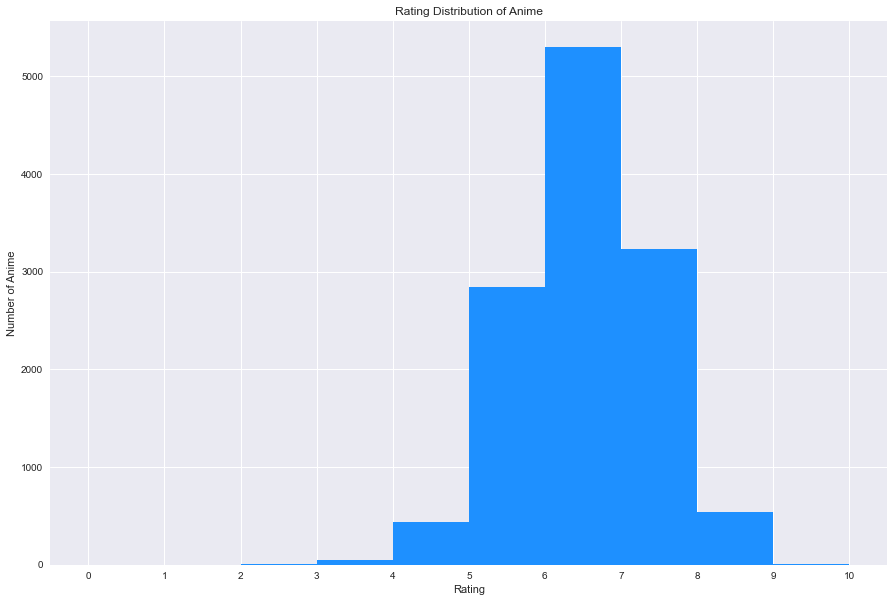

In [7]:
anime_data.drop(anime_data.index[anime_data["Score"] == "Unknown"], inplace=True) # remove anime with unknown ratings
anime_data["Score"] = pd.to_numeric(anime_data["Score"])
anime_data["rounded_score"] = anime_data["Score"].apply(np.floor)


plt.figure(figsize=(15,10))
plt.style.use('seaborn')

plt.hist(anime_data["rounded_score"], color="dodgerblue", bins  = range(11))
plt.title('Rating Distribution of Anime')
plt.xticks(range(11))
plt.ylabel("Number of Anime")
plt.xlabel("Rating")
plt.show()

In [8]:
n_ratings_by_user = ratings_df['user_id'].value_counts()
n_ratings_per_anime = ratings_df['anime_id'].value_counts()
#limit recommendations to those by users who've recommended 100+ anime and anime with over 20000 ratings, and to those either completed or dropped
ratings_df = ratings_df[ratings_df["watching_status"].isin([1,2])]
ratings_df = ratings_df[ratings_df['user_id'].isin(n_ratings_by_user[n_ratings_by_user >= 100].index)].copy() 
ratings_df = ratings_df[ratings_df['anime_id'].isin(n_ratings_per_anime[n_ratings_per_anime >= 20000].index)].copy() 

ratings_df.head()

,user_id,Name,anime_id,rating,watching_status
75,1,Ano Hi Mita Hana no Namae wo Bokutachi wa Mada...,9989,0,1
76,1,Ansatsu Kyoushitsu,24833,0,1
77,1,Bakuman.,7674,7,1
78,1,Black Clover,34572,0,1
79,1,Boruto: Naruto Next Generations,34566,7,1


In [9]:
Avg_Rating = np.mean(ratings_df['rating'])
print("Average Rating: {} \nNumber of Ratings: {} \nUnique Anime: {}\nUnique Users: ".format(Avg_Rating, len(ratings_df), ratings_df['anime_id'].nunique()), ratings_df['user_id'].nunique())

Average Rating: 6.3713422487674745 
Number of Ratings: 49095534 
Unique Anime: 1501
Unique Users:  241288


In [10]:
pivottable = ratings_df.pivot_table(index="Name",columns="user_id", values="rating").fillna(0)
pivottable

user_id,1,2,3,4,5,6,7,8,11,12,...,353389,353390,353391,353392,353393,353395,353396,353398,353400,353403
Name,,,,,,,,,,,,,,,,,,,,,
"""Bungaku Shoujo"" Movie",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//Sign,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
07-Ghost,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11eyes,0.0,0.0,0.0,0.0,0.0,7.0,6.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
3-gatsu no Lion,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,7.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zutto Mae kara Suki deshita.: Kokuhaku Jikkou Iinkai,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0
ef: A Tale of Melodies.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ef: A Tale of Memories.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,9.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0


In [11]:
matrix = csr_matrix(pivottable.values)
model = NearestNeighbors(metric="cosine", algorithm= 'brute')
model.fit(matrix)
pd.set_option('display.max_colwidth', None)

In [12]:
def predict(anime_name):

    query = pivottable.loc[anime_name, :].values.reshape(1, -1)
    distance, suggestions = model.kneighbors(query, n_neighbors=6)

    data = []
    for i in range(0, len(distance.flatten())):
        if i == 0:
            print("Suggestions for {}".format(anime_name))
        else:
            details = []
            details.append(pivottable.index[suggestions.flatten()[i]])
            details.append(synopsis_df[synopsis_df.Name == pivottable.index[suggestions.flatten()[i]]].sypnopsis.values[0])
            details.append(round(distance.flatten()[i], 4))
            data.append(details)
    recommendation_df = pd.DataFrame(data, columns = ["Anime", "Synopsis", "Distance"])
    return recommendation_df

Let's look at some sample predictions

In [13]:
predict("Naruto")

Suggestions for Naruto


,Anime,Synopsis,Distance
0,Naruto: Shippuuden,"It has been two and a half years since Naruto Uzumaki left Konohagakure, the Hidden Leaf Village, for intense training following events which fueled his desire to be stronger. Now Akatsuki, the mysterious organization of elite rogue ninja, is closing in on their grand plan which may threaten the safety of the entire shinobi world. Although Naruto is older and sinister events loom on the horizon, he has changed little in personality—still rambunctious and childish—though he is now far more confident and possesses an even greater determination to protect his friends and home. Come whatever may, Naruto will carry on with the fight for what is important to him, even at the expense of his own body, in the continuation of the saga about the boy who wishes to become Hokage.",0.2471
1,Death Note,"shinigami, as a god of death, can kill any person—provided they see their victim's face and write their victim's name in a notebook called a Death Note. One day, Ryuk, bored by the shinigami lifestyle and interested in seeing how a human would use a Death Note, drops one into the human realm. High school student and prodigy Light Yagami stumbles upon the Death Note and—since he deplores the state of the world—tests the deadly notebook by writing a criminal's name in it. When the criminal dies immediately following his experiment with the Death Note, Light is greatly surprised and quickly recognizes how devastating the power that has fallen into his hands could be. With this divine capability, Light decides to extinguish all criminals in order to build a new world where crime does not exist and people worship him as a god. Police, however, quickly discover that a serial killer is targeting criminals and, consequently, try to apprehend the culprit. To do this, the Japanese investigators count on the assistance of the best detective in the world: a young and eccentric man known only by the name of L.",0.3422
2,Shingeki no Kyojin,"Centuries ago, mankind was slaughtered to near extinction by monstrous humanoid creatures called titans, forcing humans to hide in fear behind enormous concentric walls. What makes these giants truly terrifying is that their taste for human flesh is not born out of hunger but what appears to be out of pleasure. To ensure their survival, the remnants of humanity began living within defensive barriers, resulting in one hundred years without a single titan encounter. However, that fragile calm is soon shattered when a colossal titan manages to breach the supposedly impregnable outer wall, reigniting the fight for survival against the man-eating abominations. After witnessing a horrific personal loss at the hands of the invading creatures, Eren Yeager dedicates his life to their eradication by enlisting into the Survey Corps, an elite military unit that combats the merciless humanoids outside the protection of the walls. Based on Hajime Isayama's award-winning manga, Shingeki no Kyojin follows Eren, along with his adopted sister Mikasa Ackerman and his childhood friend Armin Arlert, as they join the brutal war against the titans and race to discover a way of defeating them before the last walls are breached.",0.3612
3,Fullmetal Alchemist: Brotherhood,"""In order for something to be obtained, something of equal value must be lost."" Alchemy is bound by this Law of Equivalent Exchange—something the young brothers Edward and Alphonse Elric only realize after attempting human transmutation: the one forbidden act of alchemy. They pay a terrible price for their transgression—Edward loses his left leg, Alphonse his physical body. It is only by the desperate sacrifice of Edward's right arm that he is able to affix Alphonse's soul to a suit of armor. Devastated and alone, it is the hope that they would both eventually return to their original bodies that gives Edward the inspiration to obtain metal limbs called ""automail"" and become a state alchemist, the Fullmetal Alchemist. Three ye

In [14]:
predict("Sword Art Online")

Suggestions for Sword Art Online


,Anime,Synopsis,Distance
0,Sword Art Online II,"ar after escaping Sword Art Online, Kazuto Kirigaya has been settling back into the real world. However, his peace is short-lived as a new incident occurs in a game called Gun Gale Online, where a player by the name of Death Gun appears to be killing people in the real world by shooting them in-game. Approached by officials to assist in investigating the murders, Kazuto assumes his persona of Kirito once again and logs into Gun Gale Online, intent on stopping the killer. Once inside, Kirito meets Sinon, a highly skilled sniper afflicted by a traumatic past. She is soon dragged in his chase after Death Gun, and together they enter the Bullet of Bullets, a tournament where their target is sure to appear. Uncertain of Death Gun's real powers, Kirito and Sinon race to stop him before he has the chance to claim another life. Not everything goes smoothly, however, as scars from the past impede their progress. In a high-stakes game where the next victim could easily be one of them, Kirito puts his life on the line in the virtual world once more.",0.1908
1,Shingeki no Kyojin,"Centuries ago, mankind was slaughtered to near extinction by monstrous humanoid creatures called titans, forcing humans to hide in fear behind enormous concentric walls. What makes these giants truly terrifying is that their taste for human flesh is not born out of hunger but what appears to be out of pleasure. To ensure their survival, the remnants of humanity began living within defensive barriers, resulting in one hundred years without a single titan encounter. However, that fragile calm is soon shattered when a colossal titan manages to breach the supposedly impregnable outer wall, reigniting the fight for survival against the man-eating abominations. After witnessing a horrific personal loss at the hands of the invading creatures, Eren Yeager dedicates his life to their eradication by enlisting into the Survey Corps, an elite military unit that combats the merciless humanoids outside the protection of the walls. Based on Hajime Isayama's award-winning manga, Shingeki no Kyojin follows Eren, along with his adopted sister Mikasa Ackerman and his childhood friend Armin Arlert, as they join the brutal war against the titans and race to discover a way of defeating them before the last walls are breached.",0.2357
2,No Game No Life,"No Game No Life is a surreal comedy that follows Sora and Shiro, shut-in NEET siblings and the online gamer duo behind the legendary username ""Blank."" They view the real world as just another lousy game; however, a strange e-mail challenging them to a chess match changes everything—the brother and sister are plunged into an otherworldly realm where they meet Tet, the God of Games. The mysterious god welcomes Sora and Shiro to Disboard, a world where all forms of conflict—from petty squabbles to the fate of whole countries—are settled not through war, but by way of high-stake games. This system works thanks to a fundamental rule wherein each party must wager something they deem to be of equal value to the other party's wager. In this strange land where the very idea of humanity is reduced to child's play, the indifferent genius gamer duo of Sora and Shiro have finally found a real reason to keep playing games: to unite the sixteen races of Disboard, defeat Tet, and become the gods of this new, gaming-is-everything world.",0.2514
3,Angel Beats!,"Otonashi awakens only to learn he is dead. A rifle-toting girl named Yuri explains that they are in the afterlife, and Otonashi realizes the only thing he can remember about himself is his name. Yuri tells him that she leads the Shinda Sekai Sensen (Afterlife Battlefront) and wages war against a girl named Tenshi. Unable to believe Yuri's claims that Tenshi is evil, Otonashi attempts to speak with her, but the encounter doesn't go as he intended. Otonashi decides to join the SSS and battle Tenshi, but he finds himself oddly drawn to her. While tryi

In [15]:
predict("Haikyuu!!")

Suggestions for Haikyuu!!


,Anime,Synopsis,Distance
0,Haikyuu!! Second Season,"Following their participation at the Inter-High, the Karasuno High School volleyball team attempts to refocus their efforts, aiming to conquer the Spring tournament instead. When they receive an invitation from long-standing rival Nekoma High, Karasuno agrees to take part in a large training camp alongside many notable volleyball teams in Tokyo and even some national level players. By playing with some of the toughest teams in Japan, they hope not only to sharpen their skills, but also come up with new attacks that would strengthen them. Moreover, Hinata and Kageyama attempt to devise a more powerful weapon, one that could possibly break the sturdiest of blocks. Facing what may be their last chance at victory before the senior players graduate, the members of Karasuno's volleyball team must learn to settle their differences and train harder than ever if they hope to overcome formidable opponents old and new—including their archrival Aoba Jousai and its world-class setter Tooru Oikawa.",0.1099
1,Haikyuu!!: Karasuno Koukou vs. Shiratorizawa Gakuen Koukou,"fter the victory against Aoba Jousai High, Karasuno High School, once called “a fallen powerhouse, a crow that can’t fly,” has finally reached the climax of the heated Spring tournament. Now, to advance to nationals, the Karasuno team has to defeat the powerhouse Shiratorizawa Academy. Karasuno’s greatest hurdle is their adversary’s ace, Wakatoshi Ushijima, the number one player in the Miyagi Prefecture, and one of the country’s top three aces. Only the strongest team will make it to the national tournament. Since this match is the third-year players’ last chance to qualify for nationals, Karasuno has to use everything they learned during the training camp and prior matches to attain victory. Filled with restlessness and excitement, both teams are determined to come out on top in the third season of Haikyuu!! .",0.1751
2,Kuroko no Basket,"Teikou Junior High School's basketball team is crowned champion three years in a row thanks to five outstanding players who, with their breathtaking and unique skills, leave opponents in despair and fans in admiration. However, after graduating, these teammates, known as ""The Generation of Miracles"", go their separate ways and now consider each other as rivals. At Seirin High School, two newly recruited freshmen prove that they are not ordinary basketball players: Taiga Kagami, a promising player returning from the US, and Tetsuya Kuroko, a seemingly ordinary student whose lack of presence allows him to move around unnoticed. Although Kuroko is neither athletic nor able to score any points, he was a member of Teikou's basketball team, where he played as the ""Phantom Sixth Man,"" who easily passed the ball and assisted his teammates. Kuroko no Basket follows the journey of Seirin's players as they attempt to become the best Japanese high school team by winning the Interhigh Championship. To reach their goal, they have to cross pathways with several powerful teams, some of which have one of the five players with godlike abilities, whom Kuroko and Taiga make a pact to defeat.",0.3783
3,Boku no Hero Academia,"The appearance of ""quirks,"" newly discovered super powers, has been steadily increasing over the years, with 80 percent of humanity possessing various abilities from manipulation of elements to shapeshifting. This leaves the remainder of the world completely powerless, and Izuku Midoriya is one such individual. Since he was a child, the ambitious middle schooler has wanted nothing more than to be a hero. Izuku's unfair fate leaves him admiring heroes and taking notes on them whenever he can. But it seems that his persistence has borne some fruit: Izuku meets the number one hero and his personal idol, All Might. All Might's quirk is a unique ability that can be inherited, and he has chosen Izuku to be his successor! Enduring many months of grueling training, Izuku enrolls in UA High, a p

### Important Notes:

- Anime with a high score in general are much more likely to be recommended, regardless of which anime the recommendations are based on. This can be seen with Shingeki No Kyojin (Attack on Titan) being recommended very often despite not necessarily being incredibly similar to the other anime

- Sequels + Prequels to the anime are very likely to be recommended
